# 基于 AltCLIP 的图像分类
图像分类（Image Classification）是计算机视觉中的基础任务：给定一张图像，从预定义的类别集合中判断该图像属于哪一类。

## 图像分类经典技术路线简述
图像分类技术发展大致经历了下述四个过程。
### 传统特征工程
通过手工特征（如 SIFT、HOG、LBP 等）配合机器学习分类器（SVM、KNN、Random Forest）完成分类。优点是可解释性强，缺点是对复杂场景适应性弱、迁移性差。

### 卷积神经网络（CNN）时代
以 AlexNet (2012) 为里程碑，随后 VGG、GoogLeNet、ResNet、DenseNet 等架构快速发展。特点是端到端自动学习特征，性能与泛化显著提升。
工程上常见做法是 迁移学习/微调（fine-tuning）：在 ImageNet 等大规模数据上预训练，再在下游小数据集上微调。

### Transformer 与视觉预训练
Vision Transformer (ViT) 将 NLP 的 Transformer 引入视觉，配合自监督/弱监督预训练（MAE、DINO、BEiT 等）进一步提升表现。

### 跨模态对齐与 CLIP 
CLIP（Contrastive Language-Image Pretraining）通过图像-文本配对的对比学习，让图像与自然语言在同一语义空间中对齐。带来一个重要性质：零样本识别（Zero-shot）——不需要针对你的数据训练分类头，只要写好文本提示（prompts），就能做分类。

因此这里基于CLIP衍生模型系列完成图像分类任务，选用AltCLIP模型进行实现。AltCLIP 是 CLIP 的一个变体/系列模型（BAAI 发布），保留了图像编码器 + 文本编码器 + 对比学习的基本思想，同时在多语言对齐、域适配等方面做了增强（在中文环境也常用）。AltCLIP 与 CLIP 一样，将图像和文本投到同一个语义向量空间。只需把“类别名”写成自然语言提示（如 “a photo of a cat”），然后计算图像向量与各个文本提示向量的相似度，最后用 Softmax 就能得到类别概率分布，从而实现零样本图像分类。

## 环境准备
开发者拿到香橙派开发板后，首先需要进行硬件资源确认，镜像烧录及CANN和MindSpore版本的升级，才可运行该案例，具体如下：

开发板：香橙派AIpro 24G 20T开发板  
开发板镜像: Ubuntu镜像  
CANN Toolkit/Kernels：8.0.0.beta1  
MindSpore: 2.6.0  
MindSpore NLP: 0.4.1  
Python: 3.9

### 镜像烧录
运行该案例需要烧录香橙派官网ubuntu镜像，烧录流程参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--镜像烧录](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html) 章节。

### CANN升级
CANN升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--CANN升级](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html)章节。

### MindSpore升级
MindSpore升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--MindSpore升级](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html)章节。

### AltCLIP模型权重加载
基于MindSpore NLP框架加载`BAAI/AltCLIP`模型权重。
注意：首次运行时请耐心等待模型下载。

In [1]:
import mindspore as ms
from mindnlp.transformers import AltCLIPProcessor, AltCLIPModel
from PIL import Image
import requests
import mindspore.ops as ops
from mindnlp.transformers.models.altclip import modeling_altclip

def _safe_bmm(x, y):
    x_shape = x.shape  
    y_shape = y.shape
    if len(y_shape) == 3 and y_shape[-2] == x_shape[-1]:
        y_use = y  
    else:
        y_use = ops.transpose(y, (0, 2, 1))
    return ops.matmul(x, y_use)

ops.bmm = _safe_bmm
modeling_altclip.ops.bmm = _safe_bmm

model_name = "BAAI/AltCLIP"
processor = AltCLIPProcessor.from_pretrained(model_name, cache_dir="./")
model = AltCLIPModel.from_pretrained(model_name, cache_dir="./")
model.set_train(False)  # 仅推理

/home/HwHiAiUser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/HwHiAiUser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/HwHiAiUser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/HwHiAiUser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
[WARNING] ME(25327:255086244487200,MainProcess):2025-08-24-17:45:53.672.24 [mindspore/context.py:1402]

AltCLIPModel(
  (text_model): AltCLIPTextModel(
    (roberta): AltRobertaModel(
      (embeddings): AltRobertaEmbeddings(
        (word_embeddings): Embedding(250002, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AltRobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x AltRobertaLayer(
            (attention): AltRobertaAttention(
              (self): AltRobertaSelfAttention(
                (query): Linear (1024 -> 1024)
                (key): Linear (1024 -> 1024)
                (value): Linear (1024 -> 1024)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): AltRobertaSelfOutput(
                (dense): Linear (1024 -> 1024)
                (LayerNorm): LayerNorm((1024,), eps=1e-05

# 用例图片读取加载与prompt构造

In [2]:
def load_image_from_url(url: str) -> Image.Image:
    """从 URL 读取并返回 RGB PIL.Image。"""
    resp = requests.get(url, stream=True, timeout=15)
    resp.raise_for_status()
    return Image.open(resp.raw).convert("RGB")

def classify_image_with_prompts(
    image: Image.Image,
    prompt_texts: list[str],
):
    """
    使用 AltCLIP 对一张图像与若干文本提示做零样本匹配，进而完成下游图像分类功能。
    返回：(logits_per_image, probs)
      - logits_per_image: [1, N]，图像对 N 个文本提示的相对分数
      - probs: [1, N]，softmax 概率
    """
    inputs = processor(text=prompt_texts, images=image, return_tensors="ms", padding=True)
    outputs = model(**inputs)
    logits = outputs.logits_per_image                # [1, N]
    probs = ms.ops.softmax(logits, axis=1)           # [1, N]
    return logits, probs


# 模型推理演示
演示用 COCO 的公开图片 URL 做猫 vs 狗的零样本图像分类，并打印结果，其中输出解释如下：

1) logits_per_image: 形状 [1, N]（N = 文本提示数量）
   表示“图像 vs 每个文本提示”的原始相似度分数（未归一化）。
   数值越大，说明模型认为该图像与对应文本越匹配。

2) probs: 对 logits_per_image 在类别维度做 softmax 后的结果，范围在 [0,1] 且总和=1。
   它可以理解为“各类别的归一化概率”，更直观地反映置信度。

In [8]:
# —— 基于COCO数据集进行演示 ——
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = load_image_from_url(url)

# 两个候选类别
labels = ["cat", "dog"]
# 构造 CLIP 风格提示词
texts = [f"a photo of a {lb}" for lb in labels]

# 前向推理
logits_per_image, probs = classify_image_with_prompts(image, texts)
print("logits_per_image:", logits_per_image)   # 原始相似度分数
print("probs:", probs)                         # softmax 后的概率分布

Unused or unrecognized kwargs: padding.


logits_per_image: [[16.711428  8.990479]]
probs: [[9.9955672e-01 4.4324336e-04]]


计算得到匹配分数与概率后，对最终分类结果进行总结以及可视化展示


[最终判定] Top-1 = cat  (prob = 0.999557)


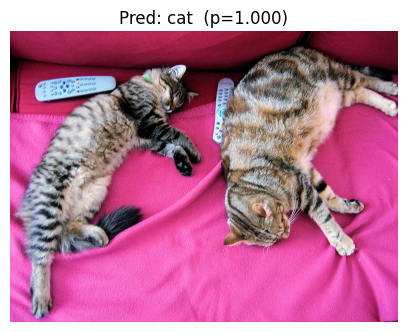

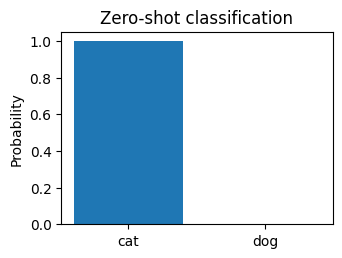

In [9]:
# 取 Top-1 结果（映射回原始 label）
probs_np = probs.asnumpy()[0]
top_idx = int(probs_np.argmax())
top_label = labels[top_idx]   
top_prob  = float(probs_np[top_idx])

print(f"\n[最终判定] Top-1 = {top_label}  (prob = {top_prob:.6f})")

try:
    from matplotlib import pyplot as plt

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {top_label}  (p={top_prob:.3f})", fontsize=12)
    plt.show()

    # 条形图，显示 cat vs dog 概率
    plt.figure(figsize=(3.5, 2.5))
    plt.bar(labels, probs_np)
    plt.ylabel("Probability")
    plt.title("Zero-shot classification")
    plt.show()
except Exception as e:
    print("[可视化跳过]", e)